## 1. Setup

In [232]:
import tensorflow as tf
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx
from gpflow.utilities import print_summary
import tensorflow_probability as tfp
import seaborn as sns
import math
from tqdm import tqdm

In [233]:
import sys
import os
project_root = os.path.abspath("../..")
sys.path.append(project_root)

In [234]:
from efficient_graph_gp.graph_kernels import diffusion_kernel, get_normalized_laplacian, generate_noisy_samples
from efficient_graph_gp.gpflow_kernels import GraphDiffusionKernel, GraphDiffusionFastGRFKernel, GraphDiffusionPoFMKernel, GraphGeneralPoFMKernel
from utils import plot_network_graph, plot_gp_fit, compute_fro

In [235]:
def generate_random_graph_by_degree(num_nodes, average_degree, seed=42):
    probability = average_degree / (num_nodes - 1)  # Calculate edge probability from average degree
    G = nx.erdos_renyi_graph(num_nodes, probability, seed=seed, directed=False)
    return nx.to_numpy_array(G)

def gp_inference(X,Y,X_new, graph_kernel):
    model = gpflow.models.GPR(data=(X, Y), kernel=graph_kernel, mean_function=None)
    # model.likelihood.variance.prior = tfp.distributions.LogNormal(loc=np.log(0.07), scale=0.5)
    gpflow.optimizers.Scipy().minimize(model.training_loss, model.trainable_variables)
    mean, variance = model.predict_f(X_new)
    stddev = tf.sqrt(variance)
    return model, mean, stddev

def gp_inference_fixed_noise(X,Y,X_new, graph_kernel, noise_variance):
    model = gpflow.models.GPR(data=(X, Y), kernel=graph_kernel, mean_function=None)
    model.likelihood.variance.assign(noise_variance)
    gpflow.utilities.set_trainable(model.likelihood.variance, False)
    gpflow.optimizers.Scipy().minimize(model.training_loss, model.trainable_variables)
    mean, variance = model.predict_f(X_new)
    stddev = tf.sqrt(variance)
    return model, mean, stddev

def lengthscale2modulator(beta, max_expansion):
    theta = np.array([(-beta / 2) ** i / math.factorial(i) for i in range(max_expansion)])
    return theta

In [236]:
def gp_log_marginal_likelihood_terms(y, K, sigma_n):
    """
    Compute the three parts of the Gaussian Process log marginal likelihood
    (assuming mean = 0):
      1) data_fit    = -1/2 * y^T (K + sigma_n^2 I)^-1 y
      2) complexity  = -1/2 * log |K + sigma_n^2 I|
      3) constant    = -n/2 * log(2 pi)
    """
    n = len(y)
    Ky = K + sigma_n**2 * np.eye(n)
    invKy = np.linalg.inv(Ky)
    sign, logdet = np.linalg.slogdet(Ky)

    data_fit   = -0.5 * y.T  @ invKy @ y
    complexity = -0.5 * logdet
    constant   = -0.5 * n * np.log(2 * np.pi)

    return data_fit, complexity, constant


## 2. Data Generation

In [237]:
# Generate a random graph
num_nodes = 200
average_degree = 10
adjacency_matrix = generate_random_graph_by_degree(num_nodes, average_degree, seed=42)


In [238]:
# Genrate Noisy Samples from the Graph By Sampling from a GP
beta_sample = 1
noise_std = 0.01

K_true = diffusion_kernel(adjacency_matrix, beta_sample)
Y_noisy = generate_noisy_samples(K_true, noise_std=noise_std, seed=42)
X = tf.convert_to_tensor(np.arange(num_nodes, dtype=np.float64).reshape(-1, 1))
X_new = tf.convert_to_tensor(np.arange(num_nodes, dtype=np.float64).reshape(-1, 1))
Y = tf.reshape(tf.convert_to_tensor(Y_noisy, dtype=tf.float64), (-1, 1))

## 3. GP Inference

In [239]:
MAX_EXPANSION = 3

### 3.1. Analytical Ground Truth PoFM Hyperparameter $\theta_0$

In [240]:
theta_0 = lengthscale2modulator(beta_sample, MAX_EXPANSION)
print(theta_0)

[ 1.    -0.5    0.125]


### 3.2. Best Fit PoFM Hyperparameter using Exact Diffusion Kernel $\theta_1$

In [241]:
exact_kernel = GraphDiffusionKernel(adjacency_matrix, beta=0.5) # The initial beta value for optimizaiton
model, mean, stddev = gp_inference_fixed_noise(X, Y, X_new, exact_kernel, noise_variance=noise_std**2)
print_summary(model)
learned_beta_exact = model.kernel.beta.numpy()

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.beta         │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.11362 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ False       │ ()      │ float64 │ 0.0001  │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧═════════╛


In [242]:
theta_1 = lengthscale2modulator(learned_beta_exact, MAX_EXPANSION)
print(theta_1)
print(model.log_marginal_likelihood().numpy())

[ 1.         -0.5568083   0.15501774]
-169.76016098610626


### 3.3. Best Fit PoFM Hyperparameter using General PoFM Kernel $\hat{\theta}$

In [243]:
general_pofm_kernel = GraphGeneralPoFMKernel(adjacency_matrix, max_walk_length=MAX_EXPANSION)
model, mean, stddev = gp_inference_fixed_noise(X, Y, X_new, general_pofm_kernel, noise_variance=noise_std**2)
print_summary(model)

╒═════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════════════════════╕
│ name                        │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                                 │
╞═════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════════════════════╡
│ GPR.kernel.modulator_vector │ Parameter │ Identity         │         │ True        │ (3,)    │ float64 │ [ 0.84157123 -0.31218432  0.0362929 ] │
├─────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────────────────────┤
│ GPR.likelihood.variance     │ Parameter │ Softplus + Shift │         │ False       │ ()      │ float64 │ 0.00010000000000000011                │
╘═════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧════════════

In [244]:
theta_hat = model.kernel.modulator_vector.numpy()
print(theta_hat)
print(model.log_marginal_likelihood().numpy())

[ 0.84157123 -0.31218432  0.0362929 ]
-169.34595482035968


### 3.4. Grid Search to Visualize the Posterior Distribution of $\hat{\theta}$

In [245]:
def evaluate_ml_diffusion(adjacency_matrix, X, Y, beta_values, noise_variance):
    ml_values = []
    for beta in tqdm(beta_values, desc="Evaluating ML over beta (Exact Diffusion)"):
        kernel = GraphDiffusionKernel(adjacency_matrix, beta=beta)
        model = gpflow.models.GPR(data=(X, Y), kernel=kernel, mean_function=None)
        model.likelihood.variance.assign(noise_variance)
        ml_values.append(np.exp(model.log_marginal_likelihood().numpy()))
    return ml_values

def evaluate_ml_constrained_pofm(adjacency_matrix, X, Y, beta_values, noise_variance):
    ml_values = []
    for beta in tqdm(beta_values, desc="Evaluating ML over beta (PoFM)"):
        theta = lengthscale2modulator(beta, MAX_EXPANSION)
        kernel = GraphGeneralPoFMKernel(adjacency_matrix, max_walk_length=MAX_EXPANSION, modulator_vector=theta)
        model = gpflow.models.GPR(data=(X, Y), kernel=kernel, mean_function=None)
        model.likelihood.variance.assign(noise_variance)
        ml_values.append(np.exp(model.log_marginal_likelihood().numpy()))
    return ml_values

Evaluating ML over beta (PoFM): 100%|██████████| 300/300 [00:13<00:00, 22.04it/s]


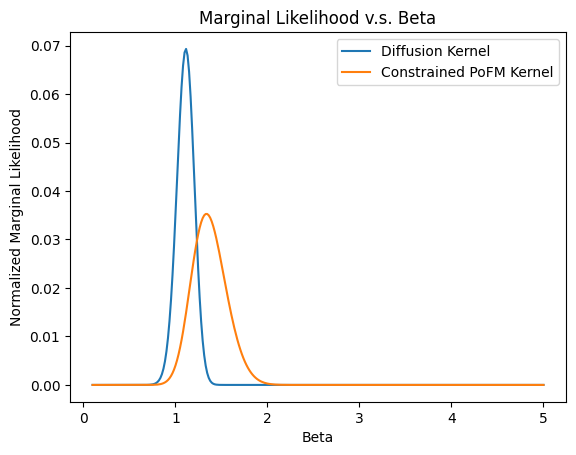

In [ ]:
# # Plot the marginal likelihood distribution to verify the correctness of the optimization

# beta_values = np.linspace(0.1, 5, 300)

# ml_values_diff = evaluate_ml_diffusion(adjacency_matrix, X, Y, beta_values, noise_std**2)
# ml_values_diff_normalized = ml_values_diff / np.sum(ml_values_diff)

# ml_values_constrained_pofm = evaluate_ml_constrained_pofm(adjacency_matrix, X, Y, beta_values, noise_std**2)
# ml_values_constrained_pofm_normalized = ml_values_constrained_pofm / np.sum(ml_values_constrained_pofm)

# plt.plot(beta_values, ml_values_diff_normalized, label="Diffusion Kernel")
# plt.plot(beta_values, ml_values_constrained_pofm_normalized, label="Constrained PoFM Kernel")
# plt.xlabel("Beta")
# plt.ylabel("Normalized Marginal Likelihood")
# plt.title("Marginal Likelihood v.s. Beta")
# plt.legend()
# plt.show()

### 3.5. Break Down the Marginal Likelihood


My guess is that the PoFM model gives better data fit term, but with larger (potentially much larger) model complexity. We can think about how to perhaps penalize the complexity.

In [180]:
ground_truth_kernel = GraphDiffusionKernel(adjacency_matrix, beta=beta_sample) # The initial beta value for optimizaiton
model = gpflow.models.GPR(data=(X, Y), kernel=ground_truth_kernel, mean_function=None)
model.likelihood.variance.assign(noise_std**2)
K_ground_truth = model.kernel.K(X).numpy()
sigma_ground_truth = np.sqrt(model.likelihood.variance.numpy())
data_fit, complexity, constant = gp_log_marginal_likelihood_terms(Y_noisy, K_ground_truth, sigma_ground_truth)

In [181]:
print('Inspecting the Log Marginal Likelihood Terms of the Ground Truth Kernel')
print('data fit: ', data_fit.squeeze())
print('negative complexity: ', complexity)
print('noise std: ', sigma_ground_truth)
print('constant: ', constant)
print('log marginal likelihood: ', data_fit.squeeze() + complexity + constant)

Inspecting the Log Marginal Likelihood Terms of the Ground Truth Kernel
data fit:  -478.7593847195245
negative complexity:  4.949499788921472
noise std:  0.010000000000000005
constant:  -918.9385332046727
log marginal likelihood:  -1392.7484181352756


In [182]:
exact_kernel = GraphDiffusionKernel(adjacency_matrix, beta=0.5) # The initial beta value for optimizaiton
model, _, _ = gp_inference_fixed_noise(X, Y, X_new, exact_kernel, noise_variance=noise_std**2)
K_exact = model.kernel.K(X).numpy()
sigma_exact = np.sqrt(model.likelihood.variance.numpy())
data_fit, complexity, constant = gp_log_marginal_likelihood_terms(Y_noisy, K_exact, sigma_exact)

In [183]:
print('Inspecting the Log Marginal Likelihood Terms of the Exact Diffusion Kernel')
print('data fit: ', data_fit.squeeze())
print('negative complexity: ', complexity)
print('noise std: ', sigma_exact)
print('constant: ', constant)
print('log marginal likelihood: ', data_fit.squeeze() + complexity + constant)

Inspecting the Log Marginal Likelihood Terms of the Exact Diffusion Kernel
data fit:  -493.20236317085653
negative complexity:  19.63019381954983
noise std:  0.010000000000000005
constant:  -918.9385332046727
log marginal likelihood:  -1392.5107025559794


In [184]:
general_pofm_kernel = GraphGeneralPoFMKernel(adjacency_matrix, max_walk_length=MAX_EXPANSION)
model, _, _, = gp_inference_fixed_noise(X, Y, X_new, general_pofm_kernel, noise_variance=noise_std**2)
K_pofm = model.kernel.K(X).numpy()
sigma_pofm = np.sqrt(model.likelihood.variance.numpy())
data_fit, complexity, constant = gp_log_marginal_likelihood_terms(Y_noisy, K_pofm, sigma_pofm)

In [185]:
print('Inspecting the Log Marginal Likelihood Terms of the PoFM Kernel')
print('data fit: ', data_fit.squeeze())
print('negative complexity: ', complexity)
print('noise std: ', sigma_pofm)
print('constant: ', constant)
print('log marginal likelihood: ', data_fit.squeeze() + complexity + constant)

Inspecting the Log Marginal Likelihood Terms of the PoFM Kernel
data fit:  -500.00022243917454
negative complexity:  27.286800739233357
noise std:  0.010000000000000005
constant:  -918.9385332046727
log marginal likelihood:  -1391.6519549046138


## 2. Error Analysis

We are interested in the performance of the PoFM Kernel:

1) It has larger search space compared to the exact diffusion, so does it have better data fit complexity?
2) We know that as the numebr of nodes increases, the ground truth diffusion kernel should be superior - dose the PoFM kernel converges to that?
3) How does the noise variance, maximum walk length, scaling factor beta affects it?
4) Overfit? (Test / Train)

### 2.1. Calculate the Frobenious Error Between the PoFM Kernel and Exact Diffusion Kernel

In [186]:
fro = compute_fro(K_pofm, K_exact)
print('Frobenius Norm between PoFM and Exact Diffusion Kernel: ', fro)

Frobenius Norm between PoFM and Exact Diffusion Kernel:  0.059099583895939035


## 3. Investigate the Performance of PoFM-kernel

### Generate Experimental Data

In [ ]:
# # Experiment Settings

# graph_sizes = [20, 40, 80, 160]
# approximation_degrees = [i for i in range(1, 10+1)]
# seeds = [0, 1, 2, 3, 4]
# betas = [0.01, 0.1, 1, 10]
# average_degree = 10
# noise_std = 0.01


# # Initialize the result dictionary
# exact_diff_results = {}
# PoFM_results = {}

In [ ]:
# for graph_size in tqdm(graph_sizes):
#     for beta_exp in betas:
#         for seed in seeds:
#             # Data Generation
#             adjacency_matrix = generate_random_graph_by_degree(graph_size, average_degree, seed=seed)
#             K_true = diffusion_kernel(adjacency_matrix, beta_exp)
#             Y_noisy = generate_noisy_samples(K_true, noise_std=noise_std, seed=seed)
#             X = tf.convert_to_tensor(np.arange(graph_size, dtype=np.float64).reshape(-1, 1))
#             X_new = tf.convert_to_tensor(np.arange(graph_size, dtype=np.float64).reshape(-1, 1))
#             Y = tf.reshape(tf.convert_to_tensor(Y_noisy, dtype=tf.float64), (-1, 1))

#             # Exact Diffusion Kernel
#             exact_kernel = GraphDiffusionKernel(adjacency_matrix, beta=0.5) # The initial beta value for optimizaiton
#             model, _, _ = gp_inference_fixed_noise(X, Y, X_new, exact_kernel, noise_variance=noise_std**2)
#             K_exact = model.kernel.K(X).numpy()
#             sigma_exact = np.sqrt(model.likelihood.variance.numpy())
#             data_fit, complexity, constant = gp_log_marginal_likelihood_terms(Y_noisy, K_exact, sigma_exact)
#             exact_diff_results[(graph_size, beta_exp, seed)] = (data_fit, complexity, constant)
            
#             # PoFM Kernel
#             for degree in approximation_degrees:
#                 general_pofm_kernel = GraphGeneralPoFMKernel(adjacency_matrix, max_walk_length=degree)
#                 model, _, _ = gp_inference_fixed_noise(X, Y, X_new, general_pofm_kernel, noise_variance=noise_std**2)
#                 K_pofm = model.kernel.K(X).numpy()
#                 sigma_pofm = np.sqrt(model.likelihood.variance.numpy())
#                 data_fit, complexity, constant = gp_log_marginal_likelihood_terms(Y_noisy, K_pofm, sigma_pofm)
#                 fro = compute_fro(K_pofm, K_exact)
#                 PoFM_results[(graph_size, beta_exp, seed, degree)] = (data_fit, complexity, constant, fro)

100%|██████████| 4/4 [04:44<00:00, 71.24s/it]


In [ ]:
# import pandas as pd

# # Convert exact_diff_results to a pandas DataFrame and write to CSV
# exact_rows = []
# for (graph_size, beta_exp, seed), (data_fit, complexity, constant) in exact_diff_results.items():
#     exact_rows.append({
#         'graph_size': graph_size,
#         'beta_exp': beta_exp,
#         'seed': seed,
#         'data_fit': data_fit,
#         'complexity': complexity,
#         'constant': constant
#     })

# df_exact = pd.DataFrame(exact_rows)
# df_exact.to_csv("exact_diff_results.csv", index=False)

# # Convert PoFM_results to a pandas DataFrame and write to CSV
# pofm_rows = []
# for (graph_size, beta_exp, seed, degree), (data_fit, complexity, constant, fro_val) in PoFM_results.items():
#     pofm_rows.append({
#         'graph_size': graph_size,
#         'beta_exp': beta_exp,
#         'seed': seed,
#         'degree': degree,
#         'data_fit': data_fit,
#         'complexity': complexity,
#         'constant': constant,
#         'fro': fro_val
#     })

# df_pofm = pd.DataFrame(pofm_rows)
# df_pofm.to_csv("PoFM_results.csv", index=False)


### Visualizations

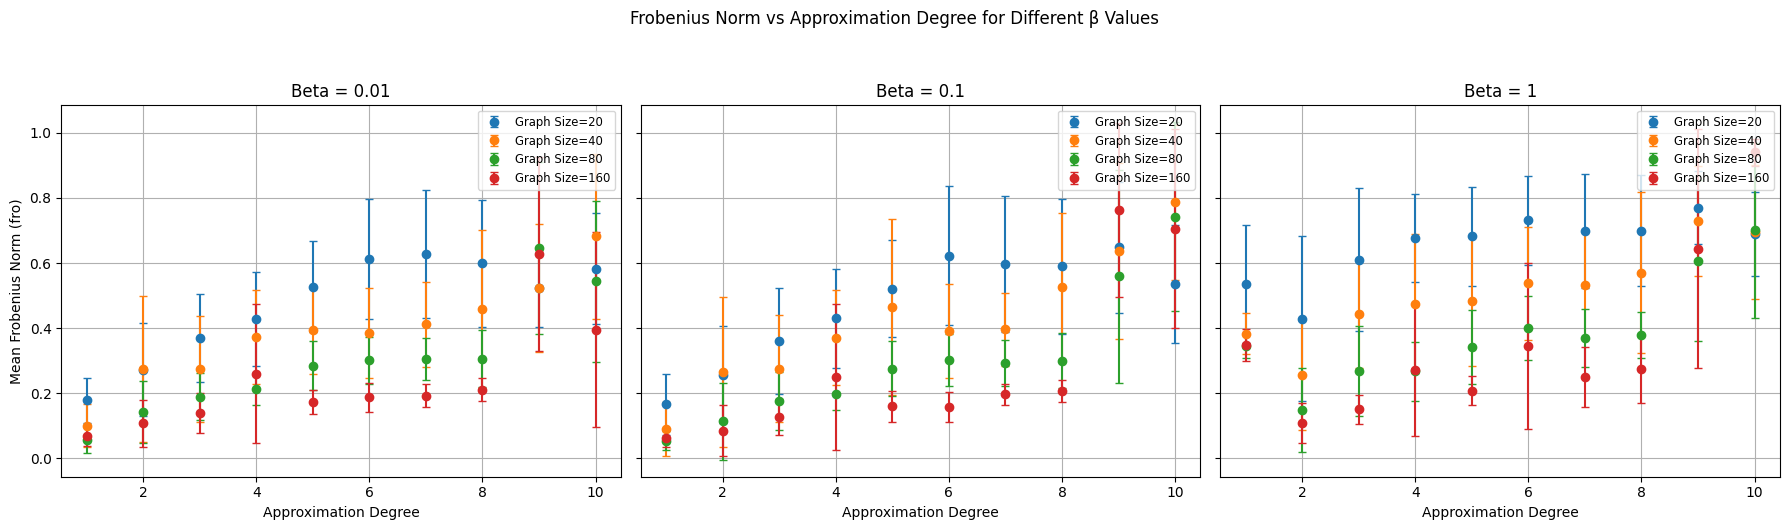

In [159]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Aggregation function
def aggregate_results(results, metric_index):
    """
    Aggregates the mean and standard deviation for a given metric index in the results dictionary.
    """
    aggregated = defaultdict(list)
    for key, values in results.items():
        graph_size, beta_exp, seed, *degree = key
        aggregated[(graph_size, beta_exp, tuple(degree))].append(values[metric_index])
    mean_std = { k: (np.mean(v), np.std(v)) for k, v in aggregated.items() }
    return mean_std

# Assuming graph_sizes, approximation_degrees, and PoFM_results are defined elsewhere
# e.g., graph_sizes = [..], approximation_degrees = [..]

# List of beta values to plot
betas = [0.01, 0.1, 1]

# Create figure and axes for 3 subplots in one row
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, beta in zip(axes, betas):
    # Filter results for the current beta value
    filtered_results = {k: v for k, v in PoFM_results.items() if k[1] == beta}

    # Aggregate Frobenius norm (assuming metric index 3 corresponds to Frobenius norm)
    fro_data = aggregate_results(filtered_results, 3)

    # Plot data for each graph size on the current axes
    for graph_size in graph_sizes:
        x = sorted(approximation_degrees)
        y = [
            fro_data.get((graph_size, beta, (degree,)), (np.nan, np.nan))[0]
            for degree in x
        ]
        y_err = [
            fro_data.get((graph_size, beta, (degree,)), (np.nan, np.nan))[1]
            for degree in x
        ]
        ax.errorbar(x, y, yerr=y_err, fmt='o', label=f"Graph Size={graph_size}", capsize=3)

    ax.set_xlabel("Approximation Degree")
    ax.set_title(f"Beta = {beta}")
    ax.grid(True)
    ax.legend(loc="upper right", fontsize="small")

# Set a common y-label for the entire row of subplots
axes[0].set_ylabel("Mean Frobenius Norm (fro)")

plt.suptitle("Frobenius Norm vs Approximation Degree for Different β Values", y=1.05)
plt.tight_layout()
plt.show()


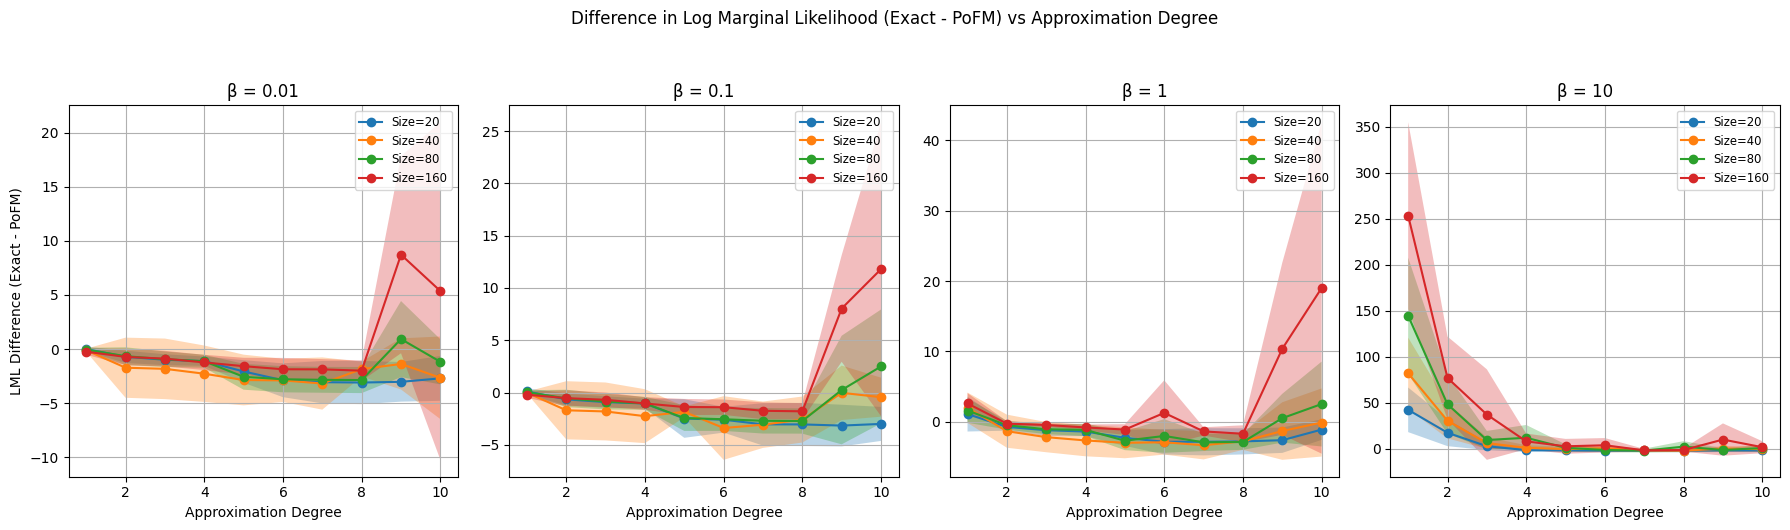

In [199]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def aggregate_lml_difference(PoFM_results, exact_results):
    """
    Aggregates the mean and standard deviation of the difference in log marginal likelihood (LML)
    between the exact diffusion and PoFM models across seeds for each
    (graph_size, beta, approximation_degree).
    The difference is calculated as: LML_exact - LML_pofm.
    """
    diff = defaultdict(list)
    for key, p_values in PoFM_results.items():
        # Unpack PoFM result key
        graph_size, beta, seed, *degree = key
        # Corresponding key for exact results (without degree info)
        exact_key = (graph_size, beta, seed)
        
        if exact_key in exact_results and degree:
            # Compute LML for PoFM and exact diffusion
            exact_values = exact_results[exact_key]
            pofm_lml = p_values[0] + p_values[1] + p_values[2]
            exact_lml = exact_values[0] + exact_values[1] + exact_values[2]
            # Compute difference for the specific approximation degree
            diff[(graph_size, beta, degree[0])].append(exact_lml - pofm_lml)
    
    # Calculate mean and std of differences across seeds
    mean_std = { k: (np.mean(v), np.std(v)) for k, v in diff.items() }
    return mean_std

# List of β values to plot
betas = [0.01, 0.1, 1, 10]

# Aggregate differences in LML between exact and PoFM models
lml_diff = aggregate_lml_difference(PoFM_results, exact_diff_results)

# Create figure and axes for 4 subplots corresponding to each β value
# Removed sharey=True to allow independent y-scales
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

for ax, beta in zip(axes, betas):
    for graph_size in graph_sizes:
        # Sort approximation degrees for consistent plotting
        x = sorted(approximation_degrees)
        means = []
        stds = []
        
        # Retrieve mean and std for each approximation degree
        for degree in x:
            mean_val, std_val = lml_diff.get((graph_size, beta, degree), (np.nan, np.nan))
            means.append(mean_val)
            stds.append(std_val)
        
        means = np.array(means)
        stds = np.array(stds)
        
        # Plot mean curve with markers
        ax.plot(x, means, marker='o', label=f"Size={graph_size}")
        # Shade the ±1 standard deviation area
        ax.fill_between(x, means - stds, means + stds, alpha=0.3)
    
    ax.set_xlabel("Approximation Degree")
    ax.set_title(f"β = {beta}")
    ax.grid(True)
    ax.legend(loc="upper right", fontsize="small")

# Setting the y-label on the first axis; others remain independent
axes[0].set_ylabel("LML Difference (Exact - PoFM)")
plt.suptitle("Difference in Log Marginal Likelihood (Exact - PoFM) vs Approximation Degree", y=1.05)
plt.tight_layout()
plt.show()

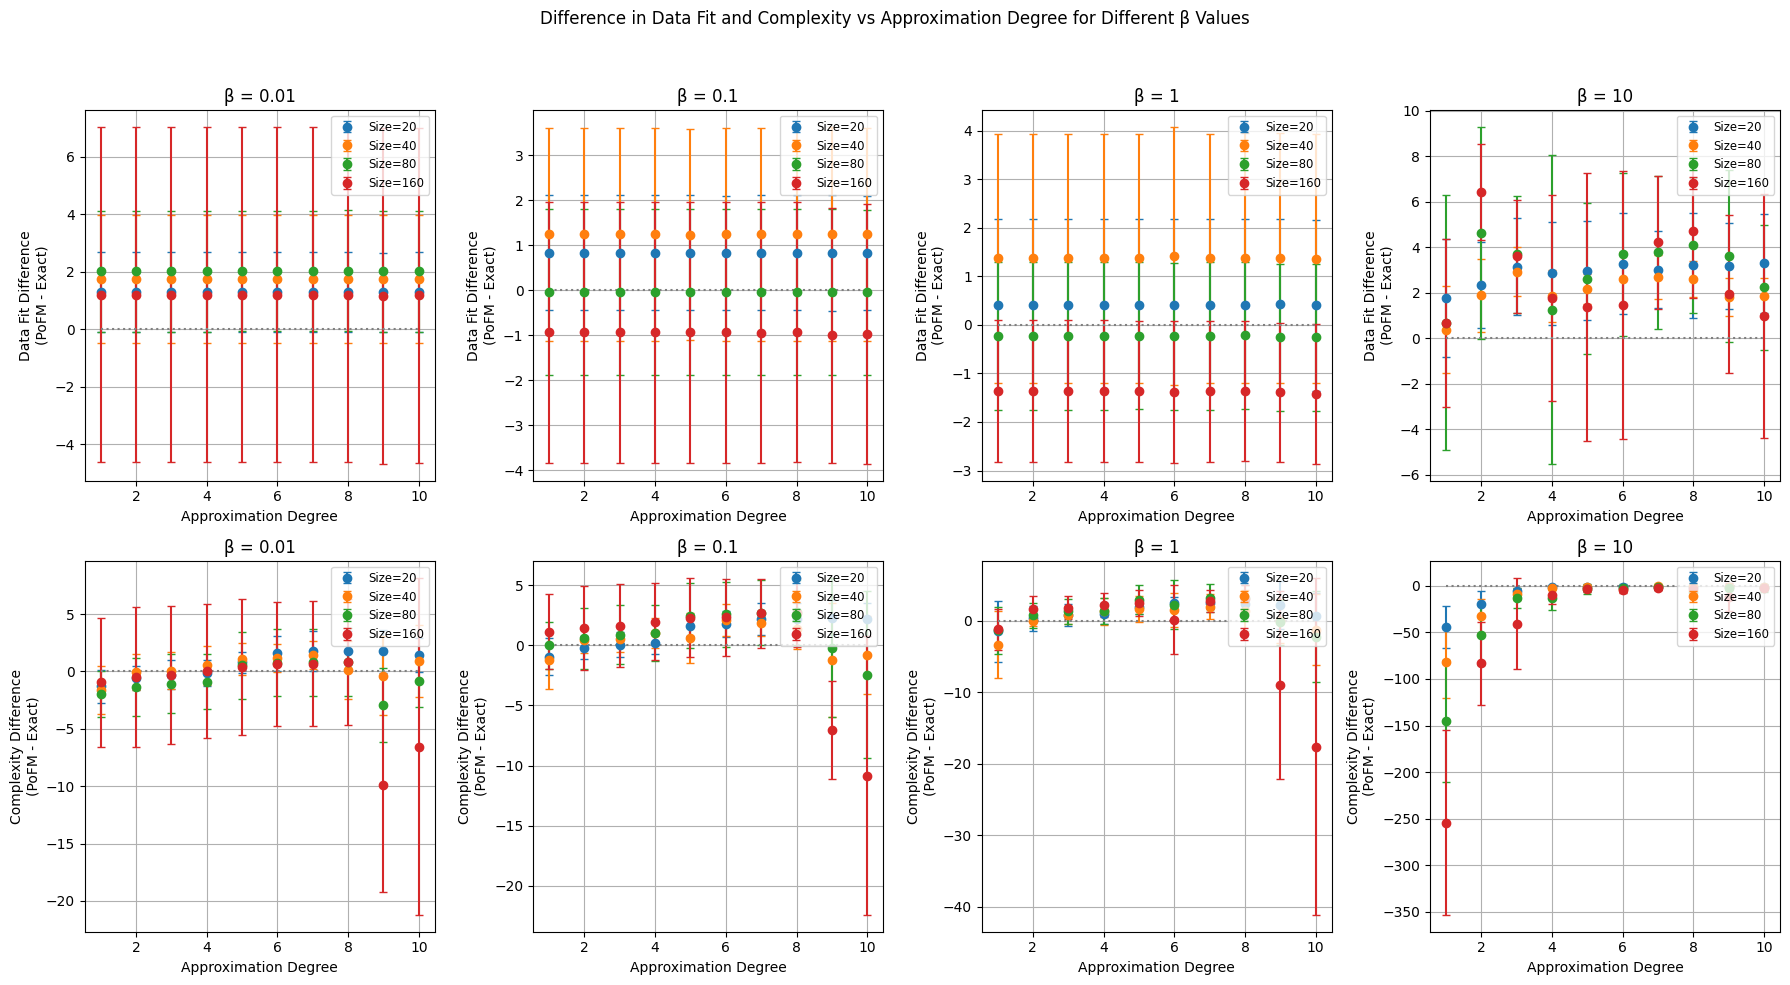

In [201]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Aggregation function for computing differences
def aggregate_difference(PoFM_results, exact_results, metric_index):
    """
    Aggregates the mean and standard deviation of the difference between 
    PoFM and exact diffusion results for a given metric (data_fit or complexity) 
    across seeds.
    """
    aggregated = defaultdict(list)
    for key, pofm_values in PoFM_results.items():
        # Unpack PoFM key: (graph_size, beta, seed, degree)
        graph_size, beta, seed, *degree = key
        # Create corresponding exact key (without degree)
        exact_key = (graph_size, beta, seed)
        
        # Ensure the exact result exists for the current key
        if exact_key in exact_results:
            exact_values = exact_results[exact_key]
            # Calculate difference for the specified metric
            diff = pofm_values[metric_index] - exact_values[metric_index]
            # Aggregate differences by (graph_size, beta, degree)
            aggregated[(graph_size, beta, degree[0])].append(diff)
    
    # Compute mean and std deviation for each aggregated key
    mean_std = { k: (np.mean(v), np.std(v)) for k, v in aggregated.items() }
    return mean_std

# Define β values of interest
betas = [0.01, 0.1, 1, 10]

# Precompute differences for data fit (metric_index=0) and complexity (metric_index=1)
diff_data_fit = aggregate_difference(PoFM_results, exact_diff_results, metric_index=0)
diff_complexity = aggregate_difference(PoFM_results, exact_diff_results, metric_index=1)

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(18, 10))

for col, beta in enumerate(betas):
    # --- Row 1: Data Fit Difference Plots ---
    ax0 = axes[0, col]
    for graph_size in graph_sizes:
        x = sorted(approximation_degrees)
        # Retrieve aggregated mean and std for differences in data fit
        y = [
            diff_data_fit.get((graph_size, beta, degree), (np.nan, np.nan))[0]
            for degree in x
        ]
        y_err = [
            diff_data_fit.get((graph_size, beta, degree), (np.nan, np.nan))[1]
            for degree in x
        ]
        ax0.errorbar(x, y, yerr=y_err, fmt='o', capsize=3, label=f"Size={graph_size}")
    
    # Reference line at 0 difference
    ax0.hlines(0, xmin=min(approximation_degrees), xmax=max(approximation_degrees), colors='gray', linestyles='dotted')
    ax0.set_title(f"β = {beta}")
    ax0.set_xlabel("Approximation Degree")
    ax0.set_ylabel("Data Fit Difference\n(PoFM - Exact)")
    ax0.grid(True)
    ax0.legend(loc="upper right", fontsize="small")

    # --- Row 2: Complexity Difference Plots ---
    ax1 = axes[1, col]
    for graph_size in graph_sizes:
        x = sorted(approximation_degrees)
        # Retrieve aggregated mean and std for differences in complexity
        y = [
            diff_complexity.get((graph_size, beta, degree), (np.nan, np.nan))[0]
            for degree in x
        ]
        y_err = [
            diff_complexity.get((graph_size, beta, degree), (np.nan, np.nan))[1]
            for degree in x
        ]
        ax1.errorbar(x, y, yerr=y_err, fmt='o', capsize=3, label=f"Size={graph_size}")
    
    # Reference line at 0 difference
    ax1.hlines(0, xmin=min(approximation_degrees), xmax=max(approximation_degrees), colors='gray', linestyles='dotted')
    ax1.set_title(f"β = {beta}")
    ax1.set_xlabel("Approximation Degree")
    ax1.set_ylabel("Complexity Difference\n(PoFM - Exact)")
    ax1.grid(True)
    ax1.legend(loc="upper right", fontsize="small")

plt.suptitle("Difference in Data Fit and Complexity vs Approximation Degree for Different β Values", y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
